In [1]:
import pandas as pd

# XGB Model

## Load the preprocessed data

In [2]:
composite_preprocessed = pd.read_csv('Composite_preprocessed_NO_MV.csv')
pd.options.display.max_columns=None
pd.options.display.max_rows=None
composite_preprocessed.head()

,Number of Stars,Number of Planets,Number of Moons,Circumbinary Flag,Discovery Year,Detected by Radial Velocity Variations,Detected by Pulsar Timing Variations,Detected by Pulsation Timing Variations,Detected by Transits,Detected by Astrometric Variations,Detected by Orbital Brightness Modulations,Detected by Microlensing,Detected by Eclipse Timing Variations,Detected by Imaging,Detected by Disk Kinematics,Controversial Flag,Galactic Latitude [deg],Galactic Longitude [deg],Ecliptic Latitude [deg],Ecliptic Longitude [deg],Number of Photometry Time Series,Number of Radial Velocity Time Series,Number of Stellar Spectra Measurements,Number of Emission Spectroscopy Measurements,Number of Transmission Spectroscopy Measurements
0,2,1,0,0,2007,1,0,0,0,0,0,0,0,0,0,0,78.28058,264.13775,18.33392,177.41790,1,2,0,0,0
1,1,1,0,0,2009,1,0,0,0,0,0,0,0,0,0,0,41.04437,108.71900,74.95821,141.64699,1,1,0,0,0
2,1,1,0,0,2008,1,0,0,0,0,0,0,0,0,0,0,-21.05141,106.41269,38.22901,11.95935,1,1,0,0,0
3,1,2,0,0,2002,1,0,0,0,0,0,0,0,0,0,0,46.94447,69.16849,62.87885,223.24717,1,4,1,0,0
4,3,1,0,0,1996,1,0,0,0,0,0,0,0,0,0,0,13.20446,83.33558,69.46803,321.21176,1,4,3,0,0


### We expect that half of these features will not have merit in predicting discovery method 
### Feature Analysis from the XGB model trained on the imbalanced, < 7% MV dataset told us these are the 5 features with most weight in the model:

### TESS Magnitude
### Ks (2MASS) Magnitude
### Orbital Period Limit Flag
### H (2MASS) Magnitude
### Planet Radius (Earth Radius) 


In [3]:
target_dummies = ['Detected by Radial Velocity Variations',
           'Detected by Pulsar Timing Variations',
           'Detected by Pulsation Timing Variations',
           'Detected by Transits',	
           'Detected by Astrometric Variations',
           'Detected by Orbital Brightness Modulations',
           'Detected by Microlensing',
           'Detected by Eclipse Timing Variations',
           'Detected by Imaging',
           'Detected by Disk Kinematics']

In [4]:
# drop rows with more than 1 discovery method before declaring features and targets
# This is to successfully apply SMOTE and to avoid giving 1 discovery method importance over the other in these cases
# classes are balanced using SMOTE regardless

composite_preprocessed = composite_preprocessed[composite_preprocessed[target_dummies].sum(axis=1) <=1]
composite_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4511 entries, 0 to 5601
Data columns (total 25 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Number of Stars                                   4511 non-null   int64  
 1   Number of Planets                                 4511 non-null   int64  
 2   Number of Moons                                   4511 non-null   int64  
 3   Circumbinary Flag                                 4511 non-null   int64  
 4   Discovery Year                                    4511 non-null   int64  
 5   Detected by Radial Velocity Variations            4511 non-null   int64  
 6   Detected by Pulsar Timing Variations              4511 non-null   int64  
 7   Detected by Pulsation Timing Variations           4511 non-null   int64  
 8   Detected by Transits                              4511 non-null   int64  
 9   Detected by Astrometric 

In [5]:
# we dropped around 1091 rows (19.5% reduction in dataset) but this doesn't mean model performance will be significantly affected
features = composite_preprocessed.drop(target_dummies, axis=1)
targets = composite_preprocessed[target_dummies]

### for xgb boost, feature columns cannot include [, ] or <
### so we will replace these characters

In [6]:
features.columns = features.columns.str.replace('[', '(').str.replace(']',')')

## Split data into training and testing

In [7]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features,targets, train_size=0.8, random_state=42)
x_train.shape, y_train.shape

((3608, 15), (3608, 10))

## Apply SMOTE to balance the classes

In [8]:
y_train.sum(axis=0)

Detected by Radial Velocity Variations         779
Detected by Pulsar Timing Variations             6
Detected by Pulsation Timing Variations          1
Detected by Transits                          2587
Detected by Astrometric Variations               2
Detected by Orbital Brightness Modulations       3
Detected by Microlensing                       162
Detected by Eclipse Timing Variations           15
Detected by Imaging                             45
Detected by Disk Kinematics                      0
dtype: int64

In [9]:
from imblearn.over_sampling import SMOTE
from sklearn.utils import column_or_1d
import numpy as np

# targets need to be 1d array for SMOTE


y_train_binary = y_train.any(axis=1)

smote = SMOTE(random_state=42)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train_binary)


# we only balance the training data ; test data will remain unbalanced to get an unbiased estimate of the model's performance

### Import and train the model

In [10]:
# in this case we will use Extreme Gradient Boosting because it is flexible, tuneable, high performing and robust against missing values
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score

In [11]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(x_train_resampled, y_train_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

## Model prediction and accuracy

In [12]:
y_pred = xgb_classifier.predict(x_test)

y_test_binary = y_test.any(axis=1)
accuracy= accuracy_score(y_test_binary,y_pred)
accuracy 

0.9889258028792912

In [13]:
clf_rep = classification_report(y_test_binary,y_pred, zero_division=1, digits=4)
print(clf_rep)

              precision    recall  f1-score   support

       False     0.1111    0.3333    0.1667         3
        True     0.9978    0.9911    0.9944       900

    accuracy                         0.9889       903
   macro avg     0.5544    0.6622    0.5805       903
weighted avg     0.9948    0.9889    0.9917       903



## XGB Classifier Model Evaluation (weighted average values accounts for class imbalances)
### Accuracy: 94.55%
### Precision: 97.54%
### Recall: 97.54% 
### F1: 97.40%
### Support: Represents the number of actual occurrences of each class in the dataset (provides context on the size of each class)
### Classes with higher support values typically have more influence on the overall evaluation metrics, while classes with lower support values may have less impact, especially in imbalanced datasets

### Overall, while the model shows good performance for most classes, it struggles to correctly predict class 1, resulting in poor precision, recall, and F1-score for that class.

# Extract and Plot Feature Importance

In [14]:
import matplotlib.pyplot as plt

feature_importance = xgb_classifier.feature_importances_
feature_names = x_train.columns

# set it up as a dataframe
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Weight': feature_importance})

# sort by importance
feature_importance_df = feature_importance_df.sort_values(by= 'Weight', ascending=False)

feature_importance_df

,Feature,Weight
1,Number of Planets,0.629835
9,Ecliptic Longitude (deg),0.127668
4,Discovery Year,0.100586
0,Number of Stars,0.074747
6,Galactic Latitude (deg),0.026086
7,Galactic Longitude (deg),0.021487
8,Ecliptic Latitude (deg),0.019591
2,Number of Moons,0.000000
3,Circumbinary Flag,0.000000
5,Controversial Flag,0.000000


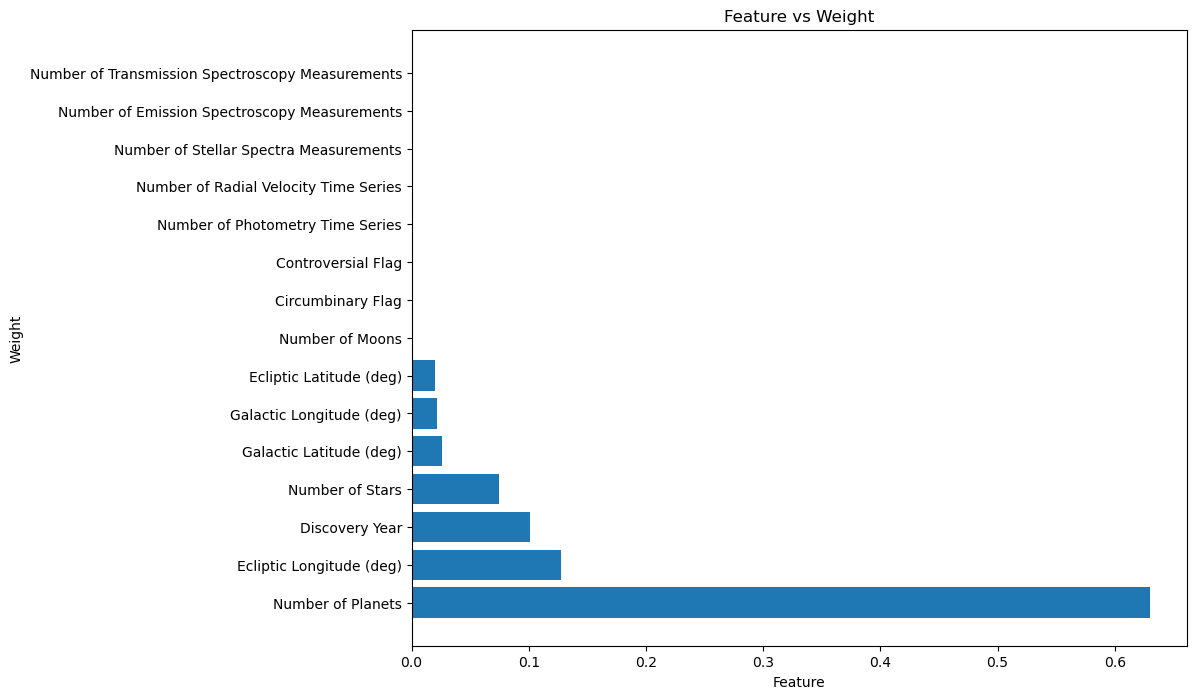

In [15]:
# Plot features by importance ; top 40 to fit in graph
n = 40
plt.figure(figsize=(10,8))
plt.barh(feature_importance_df['Feature'][:n], feature_importance_df['Weight'][:n])
plt.xlabel('Feature')
plt.ylabel('Weight')
plt.title('Feature vs Weight')
plt.show()

## The Feature Importance Plot suggests that the top 5 features with most weight in the xgb model and dataset with MV are:
### TESS Magnitude
### Ks (2MASS) Magnitude
### Orbital Period Limit Flag
### H (2MASS) Magnitude
### Planet Radius (Earth Radius) 